This tutorial covers using the simulator in SEGAR.

In [13]:
import pprint

import numpy as np

from segar.sim import Simulator


pp = pprint.PrettyPrinter(indent=4)

## The simulator

The simulator is a core component of the SEGAR research suite.
It controls:
* The underlying factors of the environment: the objects and tiles along
with their affordances
* The dynamics, conditioned on those objects and tiles, e.g., magnetism via
Lorentz's law.
* The transition function of those factors.

As such, the simulator is *separated* from the semantics of the MDP, the
task, the reward, etc. Its job is to only to manage the underlying factors
and to simulate physics.

Creating a simulator is the first step in using SEGAR:

In [14]:
sim = Simulator()

/Users/florian/dev/segar-ms/segar/__init__.py:29: UserWarning: Overwriting sim. This can have unexpected consequences if using old sim objects somewhere.
  warnings.warn(


## Adding objects

The simulator by itself isn't interesting: we need to add objects and tiles
to it.

Let's add a single ball to the middle of the field.

In [15]:
pp.pprint(sim.things)
sim.add_ball(position=np.array([0., 0.]))
pp.pprint(sim.things)

{'global_friction': Entity(id=ID(global_friction))}
{0: Object(id=ID(0)), 'global_friction': Entity(id=ID(global_friction))}


Now we have a single object in the middle of the field. Note that by
default the simulator has a square field with boundaries at (-1., 1.). Let's
look at the state of the object:

In [16]:
pp.pprint(sim.thing_states[0])

{   Order: Order(0),
    Size: Size(0.2),
    Mass: Mass(1.0),
    Density: Density(1.0),
    Charge: Charge(0.0),
    Magnetism: Magnetism(0.0),
    StoredEnergy: StoredEnergy(0.0),
    Collides: Collides(None),
    Shape: Shape(Circle(r=0.1)),
    ID: ID(0),
    Label: Label(object),
    Text: Text(B),
    Visible: Visible(True),
    Alive: Alive(True),
    Done: Done(False),
    InfiniteEnergy: InfiniteEnergy(False),
    Mobile: Mobile(True),
    Position: Position([0. 0.]),
    Velocity: Velocity([0. 0.]),
    Acceleration: Acceleration([0. 0.]),
    'cl': 'Object'}


The state contains all attributes necessary to intantiate an object, but a
number of these will be useful for building MDPs (see the `segar/mdps/README.md`
for more details).

It's good to be able to see the state of objects, but visualization can be
very useful to see what's going on. For this, we borrow a renderer from the
rendering module (see `segar/rendering/README.md` for details).

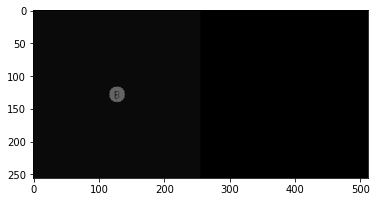

In [17]:
from segar.rendering.rgb_rendering import RGBRenderer
import PIL
from matplotlib.pyplot import imshow

renderer = RGBRenderer(annotation=True)
renderer.reset(sim)
img_arr = renderer()

image = PIL.Image.fromarray(img_arr)
imshow(image)

## Adding more objects and tiles

That's a very simple arena, but we expected that. Let's add some more things.

{   'boundaries': (-1, 1),
    'parameters': {   Friction: Friction(0.05),
                      MinMass: MinMass(0.1),
                      MaxVelocity: MaxVelocity(10.0),
                      MinVelocity: MinVelocity(0.0001),
                      Gravity: Gravity(10.0),
                      WallDamping: WallDamping(0.025),
                      <class 'segar.types.Time'>: 0.01},
    'safe_mode': False,
    'save_path': None,
    'scaling_factor': 2.8284271247461903,
    'things': {   0: {   Order: Order(0),
                         Size: Size(0.2),
                         Mass: Mass(1.0),
                         Density: Density(1.0),
                         Charge: Charge(0.0),
                         Magnetism: Magnetism(0.0),
                         StoredEnergy: StoredEnergy(0.0),
                         Collides: Collides(None),
                         Shape: Shape(Circle(r=0.1)),
                         ID: ID(0),
                         Label: Label(object),
     

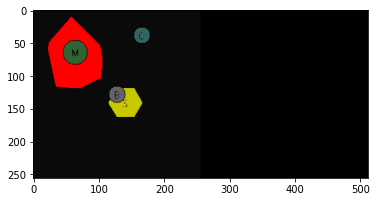

In [18]:
from segar.factors import Hexagon, RandomConvexHull, Mobile, Size, Charge, Shape

sim.add_magnet(position=np.array([-0.5, 0.5]), text='M', initial_factors={Mobile: True, Size:0.3})
sim.add_sand(position=np.array([0.1, -0.1]), text='S', initial_factors={Shape: Hexagon(0.4)})
sim.add_magma(position=np.array([-0.5, 0.5]), text='G', initial_factors={Shape: RandomConvexHull(0.3)})
sim.add_charger(position=np.array([0.3, 0.7]), text='C', initial_factors={Charge:1.0, Mobile: True})

pp.pprint(sim.state)
renderer.reset(sim)
img_arr = renderer()

image = PIL.Image.fromarray(img_arr)
imshow(image)

Note: we must reset the renderer every time we add new objects or tiles..

Let's add one more object, but misplace it on top of another. The simulator
has convenient methods for fixing overlaps.

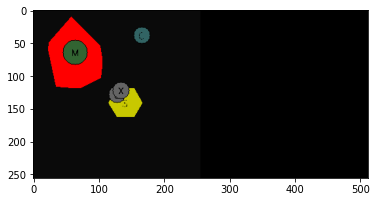

In [19]:
sim.add_ball(position=np.array([0.05, 0.05]), text='X', initial_factors={Charge: -0.5})
renderer.reset(sim)

img_arr = renderer()
image = PIL.Image.fromarray(img_arr)
imshow(image)

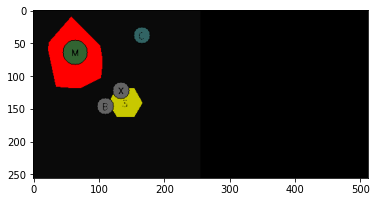

In [20]:
sim.fix_overlaps()

img_arr = renderer()
image = PIL.Image.fromarray(img_arr)
imshow(image)

## Moving the simulator forward

Now that we have some objects and tiles, let's get things moving. The
simulator method `step` will move the simulator forward. Let's apply some
force to one of the objects.

{   0: Object(id=ID(0)),
    1: Magnet(id=ID(1)),
    2: SandTile(id=ID(2)),
    3: MagmaTile(id=ID(3)),
    4: Charger(id=ID(4)),
    5: Object(id=ID(5)),
    'global_friction': Entity(id=ID(global_friction))}


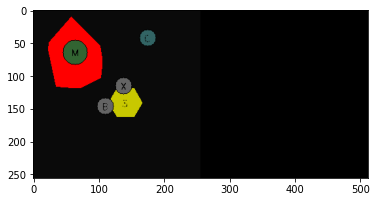

In [21]:
pp.pprint(sim.things)
sim.add_force(5, np.array([0.3, 0.7]))

for _ in range(9):
    sim.step()

img_arr = renderer()
image = PIL.Image.fromarray(img_arr)
imshow(image)

Looks like things have moved. We can even go back if we want.
Note: we have to reset the renderer because it references old object copies
kept in the history.

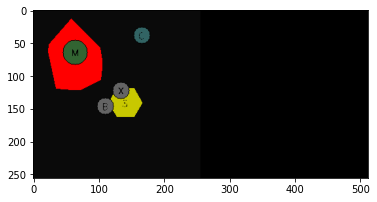

In [22]:
for _ in range(9):
    sim.rewind()

renderer.reset(sim)

img_arr = renderer()
image = PIL.Image.fromarray(img_arr)
imshow(image)

Now let's get things really moving. There are some convenient functions in
the tools module for generating and viewing trajectories.

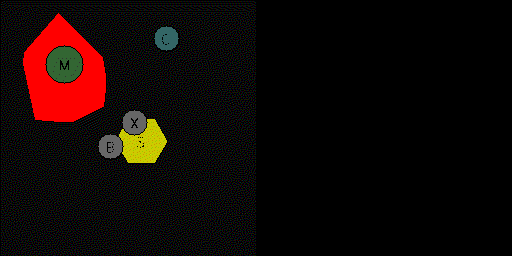

In [23]:
from IPython.display import Image

from segar.tools.sample_trajectories import rollout_sim_only, save_gif

renderer.reset(sim)
trajectories, imgs = rollout_sim_only(sim, renderer=renderer)

save_gif(imgs, out_path='../../resources/readme-images/segar/sim/trajectory_sample.gif')
Image(open('../../resources/readme-images/segar/sim/trajectory_sample.gif','rb').read())

Finally, the sim has rules. You can view the rules by checking the `rules` method:

In [24]:
pp.pprint(sim.rules)

[   segar.rules.transitions.Differential[segar.factors.arrays.Position] <- move([Position, Velocity, MinVelocity]),
    segar.rules.transitions.Aggregate[segar.factors.arrays.Acceleration] <- lorentz_law([(Position, Velocity, Charge, Magnetism), (Position, Velocity, Charge, Mass, Acceleration)]),
    segar.rules.transitions.Aggregate[segar.factors.arrays.Acceleration] <- apply_friction([(Mass, Velocity, Acceleration), (Friction,), Gravity]),
    segar.rules.transitions.SetFactor[segar.factors.number_factors.Mass] <- apply_burn([(Mass, Mobile), (Heat,)]),
    typing.Tuple[segar.rules.transitions.SetFactor[segar.factors.arrays.Velocity], segar.rules.transitions.SetFactor[segar.factors.arrays.Acceleration]] <- stop_condition([(Mobile, Alive, Velocity, Acceleration)]),
    typing.Tuple[segar.rules.transitions.SetFactor[segar.factors.number_factors.Mass], segar.rules.transitions.SetFactor[segar.factors.arrays.Velocity], segar.rules.transitions.SetFactor[segar.factors.bools.Alive], segar.rul

The rules can be added and removed from the sim. Let's remove Lorentz law, which controls how objects move according to charge and magnetism:

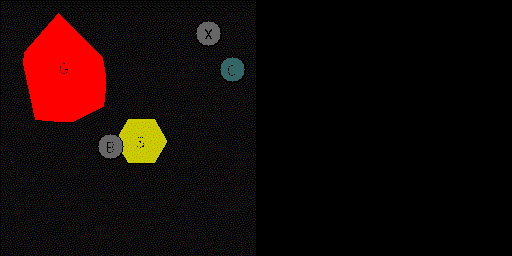

In [25]:
sim.remove_rule('lorentz_law')
trajectories, imgs = rollout_sim_only(sim, renderer=renderer)

save_gif(imgs, out_path='../../resources/readme-images/segar/sim/trajectory_sample2.gif')
Image(open('../../resources/readme-images/segar/sim/trajectory_sample2.gif','rb').read())

And there you go. The simulator and related object, tile, and shape API is
simple and easily extensible, so they should provide a clear way to build
easy-to-interpret experiments for Interactive Representation Learning.

The next suggested README is in `mdps`.